In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import learning_curve

### Load saved dataframe

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          

In [4]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother_qualification,Father_qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
# Step 1: Prepare the Data
X = df.drop(columns=['Target'])  # Features
y = df['Target']  # Target variable

In [6]:
# Step 2: Convert Target Variable to Numeric Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display the encoded labels and classes
print("Encoded Labels:", y_encoded)
print("Classes:", label_encoder.classes_)

Encoded Labels: [0 2 0 ... 0 2 2]
Classes: ['Dropout' 'Enrolled' 'Graduate']


In [7]:
y_encoded

array([0, 2, 0, ..., 0, 2, 2])

In [8]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 4: Identify Numerical Columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()


In [9]:
# Step 5: Create a Column Transformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

# Step 6: Define Hyperparameter Search Spaces
rf_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

xgb_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [1, 2, 3],
    'model__learning_rate': [0.02, 0.2, 0.4],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

In [10]:
# Step 7: Create Pipelines
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

In [11]:
# # Perform hyperparameter tuning with RandomizedSearchCV to the RandomForest pipeline
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# # Perform hyperparameter tuning with RandomizedSearchCV to the XGBoost pipeline
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


In [12]:
# Step 8: Train Models with Hyperparameter Tuning
rf_random_search.fit(X_train, y_train)
xgb_random_search.fit(X_train, y_train)

# Step 9: Make Predictions on Test Set
rf_y_pred = rf_random_search.best_estimator_.predict(X_test)
xgb_y_pred = xgb_random_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [13]:
# Step 10: Evaluation on Test Set
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_y_pred))
print(classification_report(y_test, xgb_y_pred))

Random Forest Test Accuracy: 0.7728813559322034
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       284
           1       0.59      0.37      0.46       159
           2       0.79      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.73      0.68      0.70       885
weighted avg       0.76      0.77      0.76       885

XGBoost Test Accuracy: 0.7728813559322034
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       284
           1       0.55      0.48      0.52       159
           2       0.82      0.90      0.86       442

    accuracy                           0.77       885
   macro avg       0.72      0.71      0.71       885
weighted avg       0.77      0.77      0.77       885



In [14]:
#Step 11: Using models without Hyperparameter tuning
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Step 12: Predictions on the Test Set
rf_y_pred1 = rf_pipeline.predict(X_test)
xgb_y_pred1 = xgb_pipeline.predict(X_test)

In [15]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred1))
print(classification_report(y_test, rf_y_pred1))

print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_y_pred1))
print(classification_report(y_test, xgb_y_pred1))

Random Forest Test Accuracy: 0.7661016949152543
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       284
           1       0.53      0.33      0.40       159
           2       0.79      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.77      0.75       885

XGBoost Test Accuracy: 0.7774011299435029
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       284
           1       0.55      0.48      0.52       159
           2       0.83      0.89      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.71      0.72       885
weighted avg       0.77      0.78      0.77       885



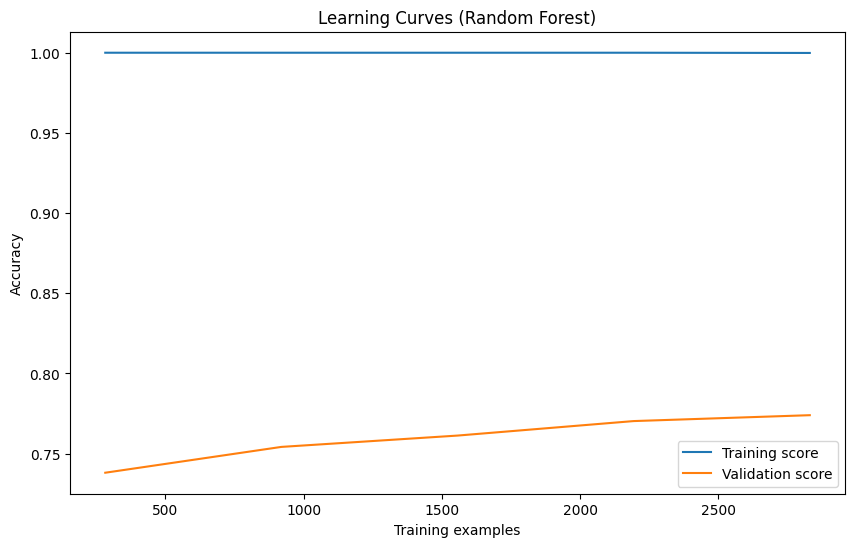

In [16]:
# Create learning curves for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.title('Learning Curves (Random Forest)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Explanation of Model Performance**:

Overfitting: The Random Forest model is perfectly fitting the training data (high accuracy on training data), but it's not generalizing well on the validation data, which could imply overfitting.

Increasing Validation Score: The validation score gradually improves as more training examples are added, but it seems to plateau around 0.75, which may suggest that the model is not able to achieve a higher score, possibly because of limitations in the data or model hyperparameters.

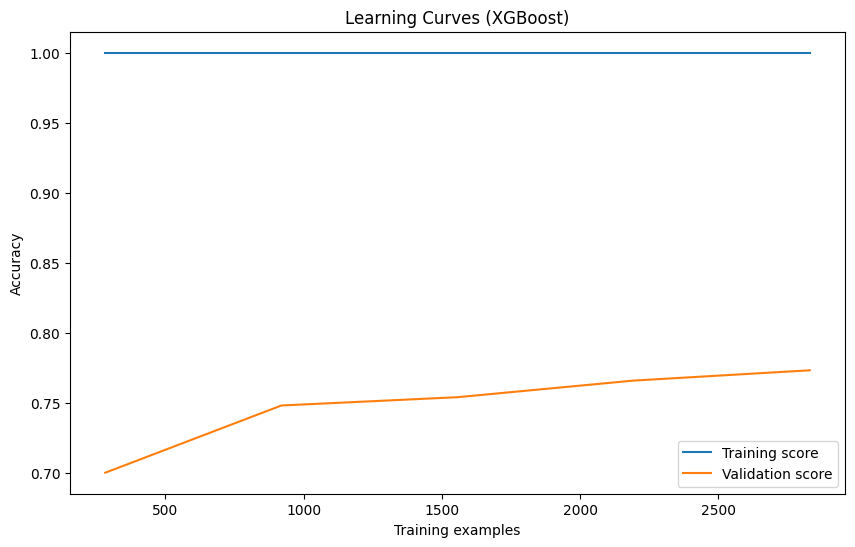

In [17]:
# Create learning curves for XGBoost
train_sizes, train_scores, test_scores = learning_curve(xgb_pipeline, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.title('Learning Curves (XGBoost)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Explanation of Model Performance**:

Overfitting: The XGBoost model perfectly fits the training data (high accuracy on training data) as in the case of the Random Forest model, but it's not generalizing well on the validation data, which could imply overfitting.

Increasing Validation Score: The validation score gradually improves as more training examples are added, but it plateaus around 0.72, which suggests that the model is not able to achieve a higher score, possibly because of limitations in the data or model hyperparameters.

In [18]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=None, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", color='blue')
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation Score", color='orange')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

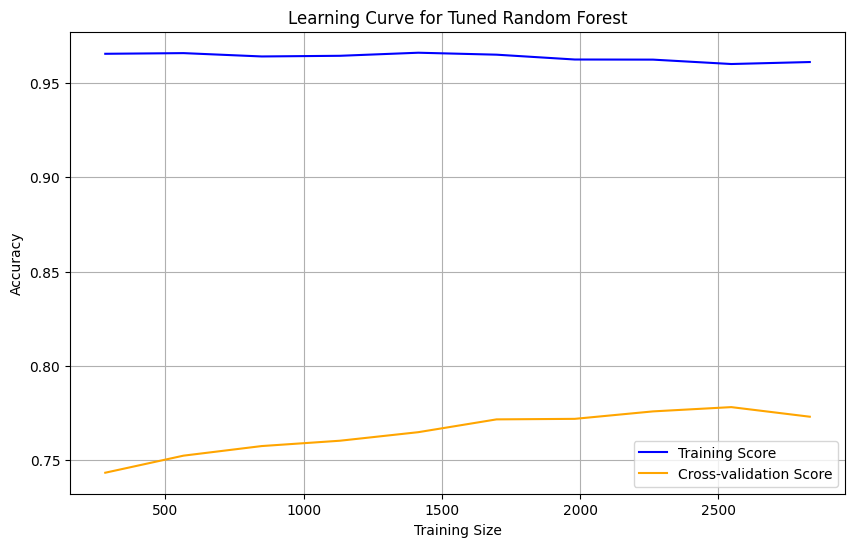

In [19]:
# Assuming rf_random_search is your tuned Random Forest model
best_rf_model = rf_random_search.best_estimator_

# Plot learning curve
plot_learning_curve(best_rf_model, X_train, y_train, title="Learning Curve for Tuned Random Forest")

**Explanation of Model Performance**:

Less Overfitting: Compared to the previous learning curve (where the training score was stuck at 1.0), this one shows that the model is no longer severely overfitting. The gap between the training score and the cross-validation score has decreased, indicating a better balance between fitting the training data and generalizing to new data.

Performance Plateau: The cross-validation score appears to plateau around 0.75-0.76, suggesting that the current model might have reached its performance limit with the given data and features.

In [20]:
# Assuming xgb_random_search is your tuned XGBoost model
best_xgb_model = xgb_random_search.best_estimator_

In [21]:
def plot_learning_curve(model, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            cv=5, n_jobs=-1)
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange')
    
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


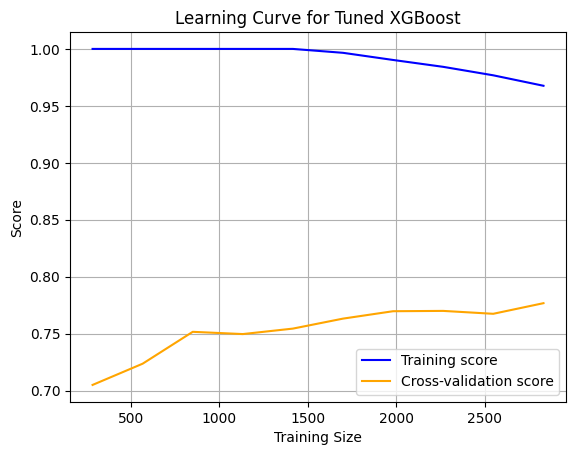

In [22]:
# Plot learning curve for the best XGBoost model
plot_learning_curve(best_xgb_model, X_train, y_train, title="Learning Curve for Tuned XGBoost")


In [23]:
# Predict with the best Random Forest model
rf_predictions = best_rf_model.predict(X_test)

# Predict with the best XGBoost model
xgb_predictions = best_xgb_model.predict(X_test)

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluation for the best Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)

print("Random Forest Model Evaluation:")
print("Accuracy:", rf_accuracy)
print("Classification Report:\n", rf_report)
print("Confusion Matrix:\n", rf_confusion)

Random Forest Model Evaluation:
Accuracy: 0.7728813559322034
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       284
           1       0.59      0.37      0.46       159
           2       0.79      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.73      0.68      0.70       885
weighted avg       0.76      0.77      0.76       885

Confusion Matrix:
 [[213  22  49]
 [ 40  59  60]
 [ 11  19 412]]


In [25]:
# Evaluation for the best XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_report = classification_report(y_test, xgb_predictions)
xgb_confusion = confusion_matrix(y_test, xgb_predictions)

print("\nXGBoost Model Evaluation:")
print("Accuracy:", xgb_accuracy)
print("Classification Report:\n", xgb_report)
print("Confusion Matrix:\n", xgb_confusion)



XGBoost Model Evaluation:
Accuracy: 0.7728813559322034
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       284
           1       0.55      0.48      0.52       159
           2       0.82      0.90      0.86       442

    accuracy                           0.77       885
   macro avg       0.72      0.71      0.71       885
weighted avg       0.77      0.77      0.77       885

Confusion Matrix:
 [[210  36  38]
 [ 34  77  48]
 [ 18  27 397]]


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          

In [27]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create the RFE object with the Random Forest model as the estimator
rfe = RFE(estimator=rf_model, n_features_to_select=25)  

# Fit RFE
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)


Selected Features: Index(['Application mode', 'Application order', 'Course',
       'Previous qualification (grade)', 'Mother_qualification',
       'Father_qualification', 'Mother_occupation', 'Father_occupation',
       'Admission grade', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP'],
      dtype='object')


In [28]:
# Train model with selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict with test set
y_pred_rfe = rf_model.predict(X_test[selected_features])

# Evaluate the model
print("Random Forest Test Accuracy with RFE:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))

Random Forest Test Accuracy with RFE: 0.7762711864406779
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       284
           1       0.59      0.40      0.48       159
           2       0.80      0.93      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.76      0.78      0.76       885



In [29]:
# Step 3: Fit and transform the training data using the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Check the shape of transformed arrays
print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)

X_train_transformed shape: (3539, 36)
X_test_transformed shape: (885, 36)


In [30]:
# Check the type of the transformed data
print("Type of X_train_transformed:", type(X_train_transformed))
print("Type of X_test_transformed:", type(X_test_transformed))

Type of X_train_transformed: <class 'numpy.ndarray'>
Type of X_test_transformed: <class 'numpy.ndarray'>


In [31]:
# Get the number of columns after transformation
n_num_cols = len(numerical_cols)
n_cat_cols = len(categorical_cols)
total_cols = n_num_cols + n_cat_cols

print("Number of Numerical Columns:", n_num_cols)
print("Number of Categorical Columns:", n_cat_cols)
print("Total Expected Columns:", total_cols)

Number of Numerical Columns: 18
Number of Categorical Columns: 18
Total Expected Columns: 36


In [32]:
# Convert the transformed arrays back into DataFrames
X_train_transformed = pd.DataFrame(X_train_transformed)
X_test_transformed = pd.DataFrame(X_test_transformed)



In [33]:
# Generate proper column names for numerical and categorical features
all_cols = list(numerical_cols) + list(categorical_cols)  # Make sure both are lists

# Check if the number of columns matches and assign names
if X_train_transformed.shape[1] == len(all_cols):
    X_train_transformed.columns = all_cols
    X_test_transformed.columns = all_cols
else:
    print("Warning: Mismatch in number of columns and provided names")



In [37]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Access the RandomForestClassifier from your best model pipeline
rf_model = best_rf_model.named_steps['model']

# Apply RFE
rfe = RFE(estimator=rf_model, n_features_to_select=30)
rfe.fit(X_train_transformed, y_train)

# Get the selected features
selected_features = X_train_transformed.columns[rfe.support_]
print("Selected Features (RFE):", selected_features)


Selected Features (RFE): Index(['Previous qualification (grade)', 'Admission grade',
       'Age at enrollment', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Application mode', 'Application order',
       'Course', 'Previous qualification', 'Mother_qualification',
       'Father_qualification', 'Mother_occupation', 'Father_occupation',
       'Displaced', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder'],
      dtype='object')


In [38]:
# Transform the training and testing data with selected features
X_train_rfe = rfe.transform(X_train_transformed)
X_test_rfe = rfe.transform(X_test_transformed)

In [39]:
rf_model.fit(X_train_rfe, y_train)
y_pred_rfe = rf_model.predict(X_test_rfe)

# Evaluate performance
print("Accuracy after RFE:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))

Accuracy after RFE: 0.7762711864406779
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       284
           1       0.58      0.39      0.47       159
           2       0.80      0.93      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.76      0.78      0.76       885



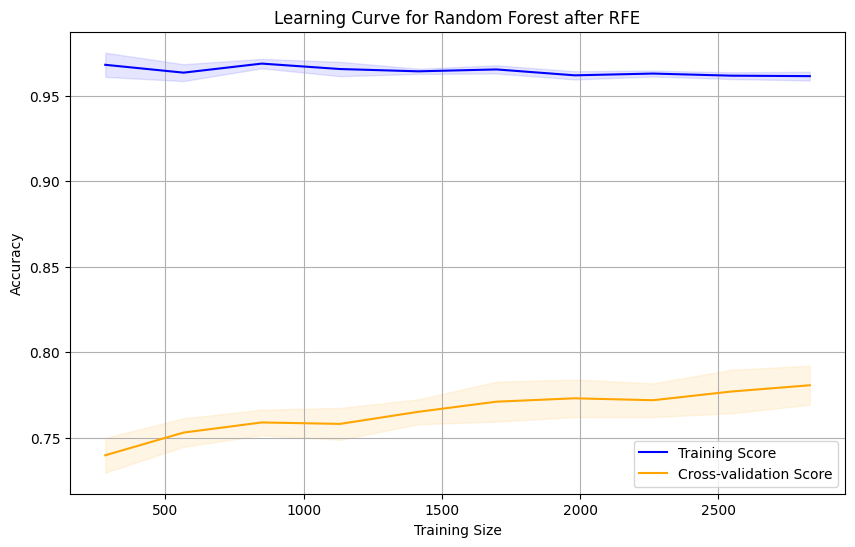

In [40]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=None, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", color='blue')
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation Score", color='orange')
    
    # Fill between the standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                     color='blue', alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                     color='orange', alpha=0.1)
    
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Assuming rf_model is your trained Random Forest model
plot_learning_curve(rf_model, X_train_rfe, y_train, title="Learning Curve for Random Forest after RFE", cv=5)


In [42]:
# Train the model on the entire dataset
best_rf_model.fit(X, y_encoded)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Previous qualification (grade)', 'Admission grade',
       'Age at enrollment', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approve...
                                                   'Nationality',
                                                   'Mother_qualification',
                                                   'Father_qualification',
                                                   'Mother_occupation',
                                                   'Father_occupation',
                                                   'Displaced',
                                                   'Educational special needs',
                                                   'Debtor',
                                                   'Tuition fees up to date',
                                                   'Gender',
                                                   'Scholarship holder',
                                                   'International'])])),
                ('model',
                 RandomForestClassifier(bootstrap=False, max_depth=15,
                                        min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=42))])

In [43]:
# Save the LabelEncoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save the model
joblib.dump(best_rf_model, 'best_rf_model.pkl')

print("Label Encoder and Model saved as label_encoder.pkl and best_rf_model.pkl")

Label Encoder and Model saved as label_encoder.pkl and best_rf_model.pkl
